# MNIST with CNN

In [1]:
#load everything
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import sys, time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

#change this five times to get 5 cross validation
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda:0


## 1. ETL: Load the MNIST

In [3]:
transform = transforms.ToTensor()
#you guys need to me after this guy, the value becomes what??
#value will be normalized to [0, 1] and also converts to tensor

In [4]:
#import os
#os.environ['http_proxy'] = 'http://192.41.170.23:3128'
#os.environ['https_proxy'] = 'http://192.41.170.23:3128'

train_data = datasets.MNIST(root="../data", train=True, 
                            download=True, transform=transform)
#split the train into train and val
#this time, Chaky won't be lazy, he will create validation set, which everyone MUST
len(train_data)

60000

In [5]:
train_set, val_set = torch.utils.data.random_split(train_data, [50000, 10000])
len(train_set), len(val_set)

(50000, 10000)

In [6]:
test_set = datasets.MNIST(root="../data", train=False, 
                            download=True, transform=transform)

8

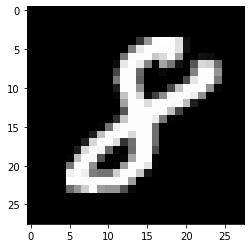

In [7]:
#challenge, show one image of a number
train_set[0][0].shape   #train_set[0] is the image, label, so [0][0] is the imge

#hint: plt.imshow
plt.imshow(train_set[0][0].reshape(28,28), cmap="gray")

#what is the label of this guy?
train_set[0][1]

## 2. Create dataloaders

In [10]:
#train batch_size = 10
#val batch_size = everything
#test batch_size = everything
#all shuffle = True

#format: DataLoader(dataset, batch_size, shuffle)

batch_size = 512

train_loader = DataLoader(train_set, batch_size=batch_size,    shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=len(val_set),  shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=len(test_set), shuffle=True, num_workers=2, pin_memory=True)


## 3. Test the dataloader

In [9]:
#run a for loop train_loader and then break, and then print out shape of image, label

# for images, label in train_loader:
#     print(images.shape)
#     print(label.shape)
#     break

#what is [10, 1, 28, 28]
#        [batch_size, c, w, h] = image
#what is [10]
#        [batch_size] = target


torch.Size([512, 1, 28, 28])
torch.Size([512])


## 3. Learn about nn.Conv2d

In [11]:
#format: nn.Conv2d(input_channel, output_channel, kernel_size, stride=1, padding=0)
#if i know my image is channel 1
#let's say I want to convert this channel 1 to 13, 
#kernel_size = 3
#stride = 1
#padding = 0
chaky_layer = nn.Conv2d(1, 13, 3, 1, 0)

In [12]:
chaky_layer

Conv2d(1, 13, kernel_size=(3, 3), stride=(1, 1))

In [13]:
#chaky_layer.weight.shape

torch.Size([13, 1, 3, 3])

In [14]:
#chaky_layer.bias.shape

torch.Size([13])

In [15]:
#can you take image for me
image = train_set[0][0]
image.shape

torch.Size([1, 28, 28])

In [16]:
image = image.reshape(1, 1, 28, 28)
out = chaky_layer(image)
out.shape
#where does [13, 26, 26] comes from???
#(input_size - k + 2P) / s +1
# (28 - 3 + 2*0) / 1 + 1

torch.Size([1, 13, 26, 26])

In [16]:
#can you create another convolution layer
#that can accept this input [13, 26, 26]
#kernel size =3, stride =1, padding = 0, output_channel = 5, input_channel = ???
chaky_layer2 = nn.Conv2d(13,5,3,1,0)
out2 = chaky_layer2(out)
print(out2.shape)
#what is [5, 24, 24]
#5 is the output_channel
#24 - do the math by yourself

torch.Size([1, 5, 24, 24])


In [17]:
image.shape

torch.Size([1, 1, 28, 28])

torch.Size([1, 128, 20, 20])
torch.Size([128, 20, 20])


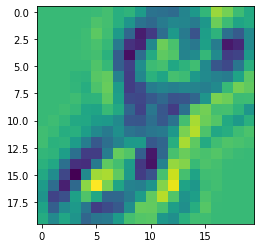

In [18]:
#create two convolutional layer
#of outputchannel 256, then 128
#kernel_size = 5, stride = 1, padding = 0
layers = nn.Sequential(nn.Conv2d(1,256,5,1,0),nn.Conv2d(256,128,5,1,0))
out3 = layers(image)
print(out3.shape)
out3 = out3.reshape(128, 20, 20)
print(out3.shape)
plt.imshow(out3[0].detach().numpy())

## 4. Learn about maxpool2d

In [19]:
pool = nn.MaxPool2d(2, 2)

In [20]:
image.shape

torch.Size([1, 1, 28, 28])

In [21]:
out = pool(image)
out.shape

torch.Size([1, 1, 14, 14])

In [22]:
#let's have break until 17:15

In [23]:
#test the sample
#random image
random_image = torch.rand((1, 1, 28, 28))
conv1 = nn.Conv2d(1, 6, 3, 1)  
conv2 = nn.Conv2d(6, 16, 3, 1)

layers = nn.Sequential(conv1, conv2)
out = layers(random_image)
out.shape  #output shape

torch.Size([1, 16, 24, 24])

## 5. Create the model

In [24]:
#convolutional neural network
class ChakyCNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        #create 2 convolutional layer (1 -> 6 -> 16)
        #stride = 1, kernel_size = 3
        self.conv1 = nn.Conv2d(1, 6, 3, 1)  #(input_size - k + 2P) / s +1
        #input w/h = (28 - 3 + 0) / 1 + 1 = 26
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        #input w/h = (24 - 3 + 0) /1 + 1 = 24
        #three linear layers here
        #1st layer - from image (b, c, w, h) --> (b, c*w*h) in order to input to linear layer
        #1st layer input_size -> 120  (input_size here is channel x w x h)
        self.linear1 = nn.Linear(16*5*5, 120)
        #2nd layer 120 -> 84
        self.linear2 = nn.Linear(120, 84)
        #3rd layer 84 -> 10  (10 is the output_size)
        self.linear3 = nn.Linear(84, 10)
        
        self.maxpool = nn.MaxPool2d(2, 2)
        self.relu    = nn.ReLU()
        
    def forward(self, image):
        #image.shape:  (B, C, W, H)
        out = self.conv1(image)  #convolution1
        #out.shape:    (B, 6, 26, 26)
        out = self.relu(out) #relu
        out = self.maxpool(out) #maxpool2d
        #out.shape:    (B, 6, 13, 13)
        
        #(input_size - k + 2P) / s +1
        # 13 - 3 / 1 + 1 = 11
        out = self.conv2(out) #convolution2
        #out.shape (B, 16, 11, 11)
        out = self.relu(out) #relu
        out = self.maxpool(out) #maxpool2d
        #out.shape (B, 16, 5, 5)
        
        #reshape so that it can be inserted into the linear layer
        out = out.reshape(-1, 16*5*5)
        
        #linear1 -> relu
        #linear2 -> relu
        #linear3
        out = self.linear1(out)
        out = self.relu(out)
        #out.shape (B, 120)
        #linear2 -> relu
        out = self.linear2(out)
        out = self.relu(out)
        #out.shape (B, 84)
        #linear3 -> relu
        out = self.linear3(out)
        #out.shape (B, 10)
        
        return out
        

## 6. Test the model for me

In [25]:
model = ChakyCNN().to(device)
random_image = torch.rand((1, 1, 28, 28)).to(device)
out = model(random_image)
print(out.shape)

torch.Size([1, 10])


## 7. Count the parameters

In [26]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [27]:
count_parameters(model)
#what is 54, 6, 864, 16....where does they come from
#total parameters is 60074
#54 comes from the first conv1 layer
#(1, 6, 3, 3)
#6 comes from the bias of the first conv1 layer
#864 comes from the second conv2 layer
#(6, 16, 3, 3) = 864
#48000 comes from???
#(5 * 5 * 16, 120) = 48000

    54
     6
   864
    16
 48000
   120
 10080
    84
   840
    10
______
 60074


## 8. Training!!!

In [27]:
J_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [28]:
epochs = 5   #too lazy to wait
val_old_loss = float("Inf")
train_losses = []
train_accs   = []
val_losses   = []
val_accs     = []
filepath = '../models/best_mnist.pt'
#for epochs
for e in range(epochs):
    #for train loader
    total_corr = 0
    for b, (image, label) in enumerate(train_loader):
        
        start_time = time.time()
        
        #image: (B, C, W, H)
        #label: (B)
        image = image.to(device)
        label = label.to(device)
        
        yhat = model(image) #1. model
        train_loss = J_fn(yhat, label) #2. loss
        
        #2.1 collect the loss and acc
        train_losses.append(train_loss)
        predicted = torch.max(yhat, 1)[1]
        batch_corr = (predicted == label).sum()
        total_corr += batch_corr
            
        optimizer.zero_grad() #3. zero_grad
        train_loss.backward() #4. backward
        optimizer.step() #5. step
        
        #print the loss and acc if epoch / 1
        train_acc = (total_corr * 100) / (batch_size * (b + 1))
        train_accs.append(train_acc)
        
        #total time
        total_time = time.time() - start_time
        
        if (b+1) % 20 == 0:
            print(f"Epoch: {e} - Batch: {b} - Train Loss: {train_loss:.2f} - Train Acc: {train_acc:.2f} - Total Time: {total_time:.2f}s")
        
    with torch.no_grad():
        val_corr = 0 
        for val_image, val_label in val_loader:
            val_image = val_image.to(device)
            val_label = val_label.to(device)
            val_yhat = model(val_image)
            val_loss = J_fn(val_yhat, val_label)
            val_predicted = torch.max(val_yhat, 1)[1]
            val_corr += (val_predicted == val_label).sum()
            if val_loss < val_old_loss:
                torch.save(model.state_dict(), filepath)
        val_acc = (val_corr * 100) / len(val_set)
    val_accs.append(val_acc)
    val_losses.append(val_loss)
    # here you MUST SAVE THE BEST MODEL whenever val_loss < val_old_loss
    ##even if it takes time, you want to do this in your thesis....
    
    print(f"++++++Validation++++++ Val Loss: {val_loss:.2f} - Val Acc: {val_acc:.2f}")


Epoch: 0 - Batch: 19 - Train Loss: 2.08 - Train Acc: 27.97 - Total Time: 0.00s
Epoch: 0 - Batch: 39 - Train Loss: 1.10 - Train Acc: 41.63 - Total Time: 0.00s
Epoch: 0 - Batch: 59 - Train Loss: 0.62 - Train Acc: 52.71 - Total Time: 0.00s
Epoch: 0 - Batch: 79 - Train Loss: 0.49 - Train Acc: 60.04 - Total Time: 0.01s
++++++Validation++++++ Val Loss: 0.43 - Val Acc: 86.63
Epoch: 1 - Batch: 19 - Train Loss: 0.45 - Train Acc: 87.18 - Total Time: 0.01s
Epoch: 1 - Batch: 39 - Train Loss: 0.30 - Train Acc: 87.99 - Total Time: 0.01s
Epoch: 1 - Batch: 59 - Train Loss: 0.31 - Train Acc: 88.73 - Total Time: 0.01s
Epoch: 1 - Batch: 79 - Train Loss: 0.31 - Train Acc: 89.47 - Total Time: 0.01s
++++++Validation++++++ Val Loss: 0.25 - Val Acc: 92.54
Epoch: 2 - Batch: 19 - Train Loss: 0.27 - Train Acc: 92.25 - Total Time: 0.01s
Epoch: 2 - Batch: 39 - Train Loss: 0.16 - Train Acc: 92.76 - Total Time: 0.01s
Epoch: 2 - Batch: 59 - Train Loss: 0.19 - Train Acc: 93.03 - Total Time: 0.00s
Epoch: 2 - Batch: 79 

In [29]:
train_losses = [loss.item() for loss in train_losses]
train_accs   = [acc.item()  for acc  in train_accs]
val_losses   = [loss.item() for loss in val_losses]
val_accs     = [acc.item()  for acc  in val_accs]

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

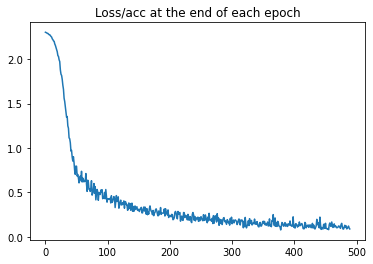

In [30]:
plt.plot(train_losses, label='training loss')
plt.title('Loss/acc at the end of each epoch')

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

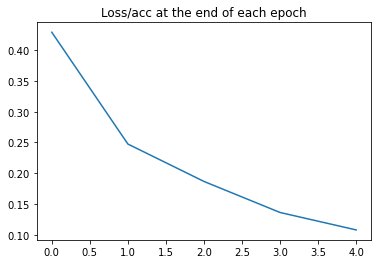

In [31]:
plt.plot(val_losses, label='validation loss')
plt.title('Loss/acc at the end of each epoch')

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

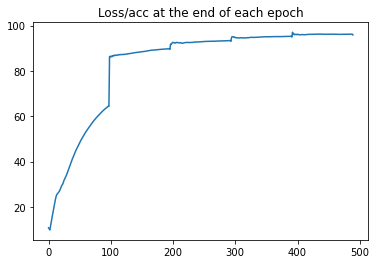

In [32]:
plt.plot(train_accs, label='training acc')
plt.title('Loss/acc at the end of each epoch')

Text(0.5, 1.0, 'Loss/acc at the end of each epoch')

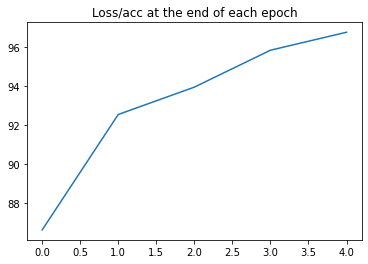

In [33]:
plt.plot(val_accs, label='validation loss')
plt.title('Loss/acc at the end of each epoch')

## 9. Testing / Inference

In [35]:
#do by yourself
#load the best model based on val loss
model = ChakyCNN().to(device)
model.load_state_dict(torch.load(filepath))

#do the testing phase! :-)
with torch.no_grad():
    test_corr = 0 
    for test_image, test_label in test_loader:
        test_image = test_image.to(device)
        test_label = test_label.to(device)
        test_yhat = model(test_image)
        test_loss = J_fn(test_yhat, test_label)
        test_predicted = torch.max(test_yhat, 1)[1]
        test_corr += (test_predicted == test_label).sum()
    test_acc = (test_corr * 100) / len(test_set)
    
print(test_acc)

tensor(97.4700, device='cuda:0')
